EMAR349 ML for the Arts - Twomey - [ml.roberttwomey.com](http://ml.roberttwomey.com)

# Tensorflow MNIST Deep Convolutional GAN

<!--__NOTE for OOD users__: select the `tf-gpu-1.14` kernel.-->

adapted from example here https://github.com/znxlwm/tensorflow-MNIST-GAN-DCGAN

Generator $G(z)$:
- $z$ - latent code (100-dim vector)
- Deconv1 - 4x4 stride 1 (1024 x 4 x 4) + Batch Norm + Leak ReLU
- Deconv2 - 4x4 stride 2 (512 x 8 x 8) + Batch Norm + Leak ReLU
- Deconv3 - 4x4 stride 2  (256 x 16 x 16) + Batch Norm + Leak ReLU
- Deconv4 - 4x4 stride 2 (128 x 32 x 32) + Batch Norm + Leak ReLU
- Deconv5 - 4x4 stride 2 (1 x 64 x 64) + TanH

Discriminator $D(x)$:
- $x$ - input image (1x64x64)
- Conv1 - 4x4 stride 1 (128 x 32 x 32) + LeakReLU
- Conv2 - 4x4 stride 2 (256 x 16 x 16) + Batch Norm + LeakReLU
- Conv3 - 4x4 stride 2 (512 x 8 x 8) + Batch Norm + LeakReLU
- Conv4 - 4x4 stride 2 (1024 x 4 x 4) + Batch Norm + LeakReLU
- Conv5 - 4x4 stride 1 (1) + Sigmoid (classifier Real/Fake)



<img src="https://github.com/roberttwomey/ml-art-code/blob/master/tf-MNIST-GAN-DCGAN/tensorflow_DCGAN.png?raw=1" width="900" align="left">

In [2]:
import os, time, itertools, imageio, pickle
import numpy as np
import matplotlib.pyplot as plt
# import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

# from tensorflow.examples.tutorials.mnist import input_data
from keras.datasets import mnist


In [3]:
def lrelu(x, th=0.2):
    return tf.maximum(th * x, x)

In [4]:
# G(z)
def generator(x, isTrain=True, reuse=False):
    with tf.variable_scope('generator', reuse=reuse):

        # 1st hidden layer
        conv1 = tf.layers.conv2d_transpose(x, 1024, [4, 4], strides=(1, 1), padding='valid')
        lrelu1 = lrelu(tf.layers.batch_normalization(conv1, training=isTrain), 0.2)

        # 2nd hidden layer
        conv2 = tf.layers.conv2d_transpose(lrelu1, 512, [4, 4], strides=(2, 2), padding='same')
        lrelu2 = lrelu(tf.layers.batch_normalization(conv2, training=isTrain), 0.2)

        # 3rd hidden layer
        conv3 = tf.layers.conv2d_transpose(lrelu2, 256, [4, 4], strides=(2, 2), padding='same')
        lrelu3 = lrelu(tf.layers.batch_normalization(conv3, training=isTrain), 0.2)

        # 4th hidden layer
        conv4 = tf.layers.conv2d_transpose(lrelu3, 128, [4, 4], strides=(2, 2), padding='same')
        lrelu4 = lrelu(tf.layers.batch_normalization(conv4, training=isTrain), 0.2)

        # output layer
        conv5 = tf.layers.conv2d_transpose(lrelu4, 1, [4, 4], strides=(2, 2), padding='same')
        o = tf.nn.tanh(conv5)

        return o

In [5]:
# D(x)
def discriminator(x, isTrain=True, reuse=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # 1st hidden layer
        conv1 = tf.layers.conv2d(x, 128, [4, 4], strides=(2, 2), padding='same')
        lrelu1 = lrelu(conv1, 0.2)

        # 2nd hidden layer
        conv2 = tf.layers.conv2d(lrelu1, 256, [4, 4], strides=(2, 2), padding='same')
        lrelu2 = lrelu(tf.layers.batch_normalization(conv2, training=isTrain), 0.2)

        # 3rd hidden layer
        conv3 = tf.layers.conv2d(lrelu2, 512, [4, 4], strides=(2, 2), padding='same')
        lrelu3 = lrelu(tf.layers.batch_normalization(conv3, training=isTrain), 0.2)

        # 4th hidden layer
        conv4 = tf.layers.conv2d(lrelu3, 1024, [4, 4], strides=(2, 2), padding='same')
        lrelu4 = lrelu(tf.layers.batch_normalization(conv4, training=isTrain), 0.2)

        # output layer
        conv5 = tf.layers.conv2d(lrelu4, 1, [4, 4], strides=(1, 1), padding='valid')
        o = tf.nn.sigmoid(conv5)

        return o, conv5

In [6]:
fixed_z_ = np.random.normal(0, 1, (25, 1, 1, 100))
def show_result(num_epoch, show = False, save = False, path = 'result.png'):
    test_images = sess.run(G_z, {z: fixed_z_, isTrain: False})

    size_figure_grid = 5
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

    for k in range(size_figure_grid*size_figure_grid):
        i = k // size_figure_grid
        j = k % size_figure_grid
        ax[i, j].cla()
        ax[i, j].imshow(np.reshape(test_images[k], (64, 64)), cmap='gray')

    label = 'Epoch {0}'.format(num_epoch)
    fig.text(0.5, 0.04, label, ha='center')

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()


In [7]:
def show_train_hist(hist, show = False, save = False, path = 'Train_hist.png'):
    x = range(len(hist['D_losses']))

    y1 = hist['D_losses']
    y2 = hist['G_losses']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

In [9]:
# training parameters
batch_size = 100
lr = 0.0002
train_epoch = 20

# # load MNIST
# mnist = input_data.read_data_sets("MNIST_data/", one_hot=True, reshape=[])

(x_train, y_train), (x_test, y_test) = mnist.load_data()
# mnist = x_train.reshape(x_train.shape[0], 784)


# variables : input
x = tf.placeholder(tf.float32, shape=(None, 64, 64, 1))
z = tf.placeholder(tf.float32, shape=(None, 1, 1, 100))
isTrain = tf.placeholder(dtype=tf.bool)

# networks : generator
G_z = generator(z, isTrain)

# networks : discriminator
D_real, D_real_logits = discriminator(x, isTrain)
D_fake, D_fake_logits = discriminator(G_z, isTrain, reuse=True)

# loss for each network
D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_real_logits, labels=tf.ones([batch_size, 1, 1, 1])))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits, labels=tf.zeros([batch_size, 1, 1, 1])))
D_loss = D_loss_real + D_loss_fake
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits, labels=tf.ones([batch_size, 1, 1, 1])))

# trainable variables for each network
T_vars = tf.trainable_variables()
D_vars = [var for var in T_vars if var.name.startswith('discriminator')]
G_vars = [var for var in T_vars if var.name.startswith('generator')]

# optimizer for each network
with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    D_optim = tf.train.AdamOptimizer(lr, beta1=0.5).minimize(D_loss, var_list=D_vars)
    G_optim = tf.train.AdamOptimizer(lr, beta1=0.5).minimize(G_loss, var_list=G_vars)

11490434/11490434 [==============================] - 0s 0us/step


<ipython-input-4-5e2246d2b79d>:6: UserWarning: `tf.layers.conv2d_transpose` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2DTranspose` instead.
  conv1 = tf.layers.conv2d_transpose(x, 1024, [4, 4], strides=(1, 1), padding='valid')
<ipython-input-4-5e2246d2b79d>:7: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  lrelu1 = lrelu(tf.layers.batch_normalization(conv1, training=isTrain), 0.2)
Instructions for updating:
Colocations handled automatically by placer.
<ipython-input-4-5e2246d2b79d>:10: UserWarning: `tf.layers.conv2d_transpose` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2DTranspose` instead.
  conv2 = tf.layers.conv2d_transpose(lrelu1, 512, 

training loop:

In [12]:
# open session and initialize all variables
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

# MNIST resize and normalization
# train_set = tf.image.resize_images(mnist.train.images, [64, 64]).eval()
train_set = tf.image.resize_images(x_train, [64, 64]).eval()
train_set = (train_set - 0.5) / 0.5  # normalization; range: -1 ~ 1

# results save folder
root = 'MNIST_DCGAN_results/'
model = 'MNIST_DCGAN_'
if not os.path.isdir(root):
    os.mkdir(root)
if not os.path.isdir(root + 'Fixed_results'):
    os.mkdir(root + 'Fixed_results')

train_hist = {}
train_hist['D_losses'] = []
train_hist['G_losses'] = []
train_hist['per_epoch_ptimes'] = []
train_hist['total_ptime'] = []

# training-loop
np.random.seed(int(time.time()))
print('training start!')
start_time = time.time()
for epoch in range(train_epoch):
    G_losses = []
    D_losses = []
    epoch_start_time = time.time()
    for iter in range(x_train.shape[0] // batch_size):
        # update discriminator
        x_ = train_set[iter*batch_size:(iter+1)*batch_size]
        z_ = np.random.normal(0, 1, (batch_size, 1, 1, 100))

        loss_d_, _ = sess.run([D_loss, D_optim], {x: x_, z: z_, isTrain: True})
        D_losses.append(loss_d_)

        # update generator
        z_ = np.random.normal(0, 1, (batch_size, 1, 1, 100))
        loss_g_, _ = sess.run([G_loss, G_optim], {z: z_, x: x_, isTrain: True})
        G_losses.append(loss_g_)

    epoch_end_time = time.time()
    per_epoch_ptime = epoch_end_time - epoch_start_time
    print('[%d/%d] - ptime: %.2f loss_d: %.3f, loss_g: %.3f' % ((epoch + 1), train_epoch, per_epoch_ptime, np.mean(D_losses), np.mean(G_losses)))
    fixed_p = root + 'Fixed_results/' + model + str(epoch + 1) + '.png'
    show_result((epoch + 1), save=True, path=fixed_p)
    train_hist['D_losses'].append(np.mean(D_losses))
    train_hist['G_losses'].append(np.mean(G_losses))
    train_hist['per_epoch_ptimes'].append(per_epoch_ptime)

end_time = time.time()
total_ptime = end_time - start_time
train_hist['total_ptime'].append(total_ptime)


/usr/local/lib/python3.10/dist-packages/tensorflow/python/client/session.py:1793: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


training start!


ValueError: Cannot feed value of shape (64, 64, 28) for Tensor Placeholder:0, which has shape (None, 64, 64, 1)

In [ ]:
print('Avg per epoch ptime: %.2f, total %d epochs ptime: %.2f' % (np.mean(train_hist['per_epoch_ptimes']), train_epoch, total_ptime))
print("Training finish!... save training results")
with open(root + model + 'train_hist.pkl', 'wb') as f:
    pickle.dump(train_hist, f)

show_train_hist(train_hist, save=True, path=root + model + 'train_hist.png')

images = []
for e in range(train_epoch):
    img_name = root + 'Fixed_results/' + model + str(e + 1) + '.png'
    images.append(imageio.imread(img_name))
imageio.mimsave(root + model + 'generation_animation.gif', images, fps=5)

Avg per epoch ptime: 92.19, total 20 epochs ptime: 1858.72
Training finish!... save training results


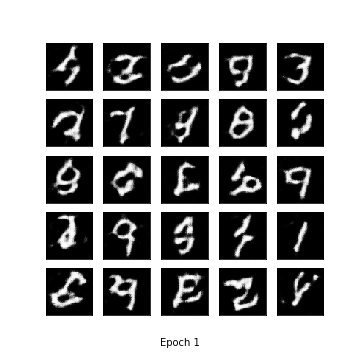

In [ ]:
from IPython.display import display, Image

with open('MNIST_DCGAN_results/MNIST_DCGAN_generation_animation.gif', 'rb') as f:
    display(Image(data=f.read(), format='png'))

## To do:
- save model checkpoint after training, to load/use later
- try with CelebA or other dataset.
- add code to sample random vector
- add code to expore learned latent embedding